In [1]:
%matplotlib inline

In [2]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

stop_words = set(stopwords.words('english'))

Using TensorFlow backend.


In [3]:
data = pd.read_csv("newcleanset.csv")
data.head()
sentiment = data["rating"] >3
sentiment = sentiment.astype(int)
#Prepare model data
model_data = pd.DataFrame({"MaxTrait":data["MaxTrait"],"text": data["text"], "sentiment":sentiment})
model_data.head()

,MaxTrait,text,sentiment
0,conscientiousness,GOOD LOOKING KICKS IF YOUR KICKIN IT OLD SCHOO...,1
1,openness,These sunglasses are all right. They were a li...,1
2,extraversion,I don't see the difference between these bodys...,1
3,extraversion,Very nice basic clothing. I think the size is ...,1
4,extraversion,I love these socks. They fit great (my 15 mont...,1


In [4]:
def remove_pun(element):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return element.translate(translator)
def remove_stopwords(element):
    element = [word.lower() for word in element.split() if word.lower() not in stop_words]
    return " ".join(element)

In [5]:
model_data["text"] = model_data["text"].apply(remove_pun)
model_data["text"] = model_data["text"].apply(remove_stopwords)
model = model_data.head()

In [6]:
#normalize personality
per = np.unique(model_data["MaxTrait"])
nor = [i+1 for i in range(per.shape[0])]
nor_map = dict(zip(per, nor))
model_data["MaxTrait"] = model_data["MaxTrait"].map(nor_map)
model_data["MaxTrait"] = model_data["MaxTrait"]*30
model_data = model_data.head(100)

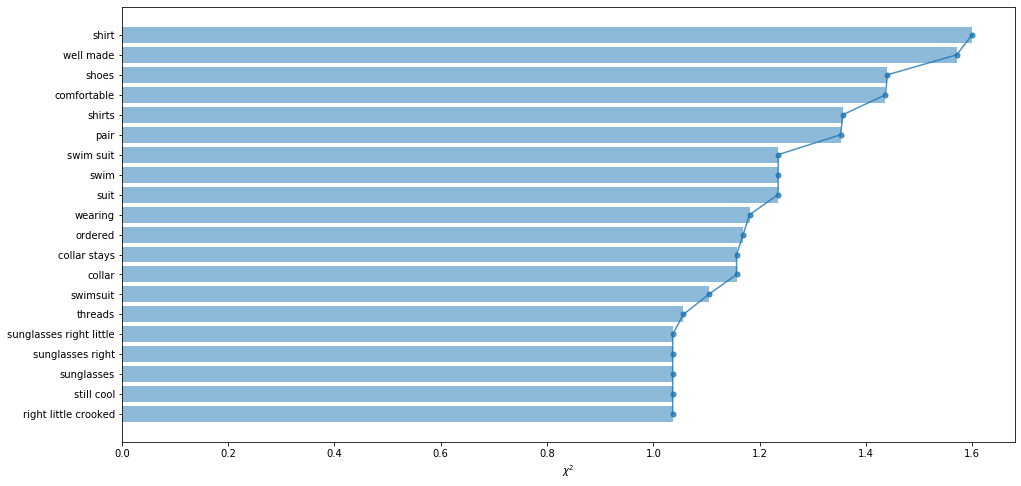

In [8]:
#feature checking
tfidf = TfidfVectorizer(max_features = 30000, ngram_range = (1,3))
x_tfidf = tfidf.fit_transform(model_data.text)
y = model_data.sentiment
chi2score = chi2(x_tfidf, y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [9]:
#for element in x_tfidf:
#    print(element)
#tfidf result document id, token id, tfidf_score

In [10]:
#LSTM no personality
max_len = 300
tokenizer = Tokenizer(num_words = max_len, split = " ")
tokenizer.fit_on_texts(model_data["text"].values)
x = tokenizer.texts_to_sequences(model_data["text"].values)
x = pad_sequences(x)
y = pd.get_dummies(model_data["sentiment"]).values
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size = 0.8, random_state = 13)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape) 

(80, 317) (80, 2)
(20, 317) (20, 2)


In [11]:
#Build LSTM model
embed_dim = 150
lstm_out = 200
model = Sequential()
model.add(Embedding(max_len, embed_dim,input_length = x.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 317, 150)          45000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 326,202
Trainable params: 326,202
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
#Train model
batch_size = 32
model.fit(x_train, y_train, epochs = 3, batch_size=batch_size, verbose = 2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/3





 - 9s - loss: 0.6857 - acc: 0.6250
Epoch 2/3
 - 4s - loss: 0.6355 - acc: 0.7750
Epoch 3/3
 - 4s - loss: 0.4949 - acc: 0.8250


In [13]:
score,acc = model.evaluate(x_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.42
acc: 0.80


In [14]:
#Initializing measure matrix
pos_count, neg_count, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(x_test)):   
    result = model.predict(x_test[x].reshape(1,x_test.shape[1]),batch_size=1,verbose = 2)[0]   
    if np.argmax(result) == np.argmax(y_test[x]):
        if np.argmax(y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1       
    if np.argmax(y_test[x]) == 0:
        neg_count += 1
    else:
        pos_count += 1
pos_acc = pos_correct/pos_count
neg_acc = neg_correct/neg_count
g_mean = sqrt(pos_acc*neg_acc)
#save performance
accuracy = np.array(acc)
g_out = np.array(g_mean)
pos = np.array(pos_acc)
neg = np.array(neg_acc)

In [15]:
#LSTM by personality
max_len = 300
tokenizer = Tokenizer(num_words = max_len, split = " ")
tokenizer.fit_on_texts(model_data["text"].values)
x = tokenizer.texts_to_sequences(model_data["text"].values)
x = pad_sequences(x)
y = pd.get_dummies(model_data["sentiment"]).values
x = pd.DataFrame(x)
x.insert(0, "MaxTrait", model_data["MaxTrait"])
x = x.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size = 0.8, random_state = 13)
#print(x_train.shape, y_train.shape)
#print(x_test.shape, y_test.shape) 

In [16]:
#Build LSTM model
embed_dim = 150
lstm_out = 100
model = Sequential()
model.add(Embedding(max_len, embed_dim,input_length = x.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 318, 150)          45000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 145,602
Trainable params: 145,602
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
batch_size = 32
model.fit(x_train, y_train, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
 - 8s - loss: 0.6862 - acc: 0.6250
Epoch 2/3
 - 4s - loss: 0.6567 - acc: 0.7875
Epoch 3/3
 - 4s - loss: 0.6114 - acc: 0.8000


In [18]:
score,acc = model.evaluate(x_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.57
acc: 0.80


In [19]:
#Initializing measure matrix
pos_count, neg_count, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(x_test)):
    
    result = model.predict(x_test[x].reshape(1,x_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(y_test[x]):
        if np.argmax(y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(y_test[x]) == 0:
        neg_count += 1
    else:
        pos_count += 1
pos_acc = pos_correct/pos_count
neg_acc = neg_correct/neg_count
g_mean = sqrt(pos_acc*neg_acc)
accuracy = np.append(accuracy, np.array(acc))
g_out = np.append(g_out,np.array(g_mean))
print(pos_acc)
print(neg_acc)
print(g_mean)
pos = np.append(pos,np.array(pos_acc))
neg = np.append(neg, np.array(neg_acc))

0.0
0.9411764705882353
0.0


In [20]:
print(accuracy)
print(g_out)
print(pos)
print(neg)

[0.80000001 0.80000001]
[0.74095857 0.        ]
[0.66666667 0.        ]
[0.82352941 0.94117647]


In [23]:
output = pd.DataFrame({"accuracy":accuracy, "g_mean":g_out, "pos":pos, "neg":neg})

In [24]:
output.to_csv("lstmoutput.csv", index = False)